# CS 6140  Mini Project - Optic Flow Model Development

### Author: Tigran Melkonian
### NUID: 001363807
### Email: melkonian.t@northeastern.edu
### Date: 11/08/2020

## Imports

In [1]:
#Import libraries/packages
import os
import cv2
import h5py 
import pickle
import ipywidgets
import numpy as np
import pandas as pd
from tqdm import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# #Import functions
# import utils
# from models import flowNetS_model, nvidia_model

In [2]:
from tensorflow import reduce_sum, multiply, pad, slice, convert_to_tensor, stack, device
from tensorflow.keras import activations

In [3]:
#Creating keras ML enviroment - TF GPU with keras as backend
from tensorflow import keras as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Layer,Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Lambda, ELU, Conv2DTranspose, Concatenate,Input, LeakyReLU, ZeroPadding2D,ZeroPadding3D,concatenate,Reshape,UpSampling2D, Dot, Convolution2D

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1812750963783774582
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2254979865335001041
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3129973145
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6256912594059336432
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 921251269566908997
physical_device_desc: "device: XLA_GPU device"
]


## Data 

In [5]:
# Defining local paths for reads and writes
DATA_PATH = 'data'
TRAIN_VIDEO = f'{DATA_PATH}\\train.mp4'
TEST_VIDEO = f'{DATA_PATH}\\test.mp4'
CLEAN_DATA_PATH = 'data\\clean_data'
CLEAN_IMGS_TRAIN = f'{CLEAN_DATA_PATH}\\train_imgs'
CLEAN_IMGS_TEST = f'{CLEAN_DATA_PATH}\\test_imgs'
ASSETS_PATH = f'{CLEAN_DATA_PATH}\\assets'

train_frames = 20400
test_frames = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


In [6]:
# Read in ground truth speed value targets for train.mp4
train_y = list(pd.read_csv(f'{DATA_PATH}\\train.txt', header=None, squeeze=True))
assert(len(train_y)==train_frames)

In [6]:
def dataset_constructor(video_loc, img_folder, tot_frames, dataset_type):
    meta_dict = {}

    tqdm.write('reading in video file...')
    tot_frames = train_frames
    cap = skvideo.io.vread(video_loc)
     
    tqdm.write('constructing dataset...')
    for idx, frame in enumerate(tqdm(cap)):    
        img_path = f'{img_folder}/{str(idx)}.jpg'
        frame_speed = float('NaN') if dataset_type == 'test' else train_y[idx]
        meta_dict[idx] = [img_path, idx, frame_speed]
        skvideo.io.vwrite(img_path, frame)
    meta_df = pd.DataFrame.from_dict(meta_dict, orient='index')
    meta_df.columns = ['image_path', 'image_index', 'speed']
    
    tqdm.write('writing meta to csv')
    meta_df.to_csv(f'{CLEAN_DATA_PATH}/{dataset_type}_meta.csv', index=False)
    
    return "done dataset_constructor"

In [9]:
# Construction train meta data from train.mp4
dataset_constructor(TRAIN_VIDEO, CLEAN_IMGS_TRAIN, train_frames, 'train')

reading in video file...
constructing dataset...


100%|██████████| 20400/20400 [23:41<00:00, 14.35it/s]


writing meta to csv
done dataset_constructor


In [7]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv'))
assert(train_meta.shape[0] == train_frames)
assert(train_meta.shape[1] == 3)
train_meta["speed"] = train_meta["speed"]

##################
# Min-Max scalar option for training - prevents loss from exploding during training process since target values range from 0 - 150+.
# NOTE - Adam optimizer used in all models does a good job in preventing loss explosion or underfitting, 
#        The Min-Max scaling step is not necessary to achieve results shown in paper
###################
# # Create a minimum and maximum processor object
# min_max_scaler = preprocessing.MinMaxScaler()

# # Create an object to transform the data to fit minmax processor
# x = min_max_scaler.fit_transform(train_meta[["speed"]].values)
# train_meta["speed"] = x


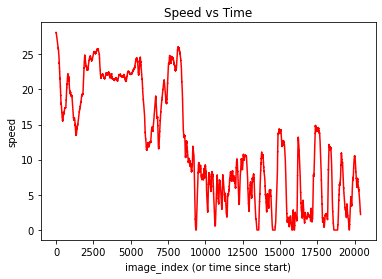

In [8]:
times = np.asarray(train_meta['image_index'], dtype = np.float32)
speeds = np.asarray(train_meta['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.show()

In [32]:
#this splitting method is to maximize the amount of data used for training inroder to yeild best generalization results
# note: there is a chance that points might appear again. as n
def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    test_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(0,len(dframe) - 1,2)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(100)
        if randInt <= 15 :
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt > 15:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [14]:
train_data, valid_data = train_valid_split(train_meta, seeds[0])

100%|██████████| 10200/10200 [00:29<00:00, 345.01it/s]


In [9]:
# Create a dedicated training and validation set for all training purposes
# NOTE: You should use the same training and validation sets for fair model comparisons since randomness in training splits may lead to varied results. 
# train_data.to_csv(os.path.join(CLEAN_DATA_PATH, 'train_data.csv'), index=False)
# valid_data.to_csv(os.path.join(CLEAN_DATA_PATH, 'valid_data.csv'), index=False)
train_data = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_data.csv'))
valid_data = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'valid_data.csv'))

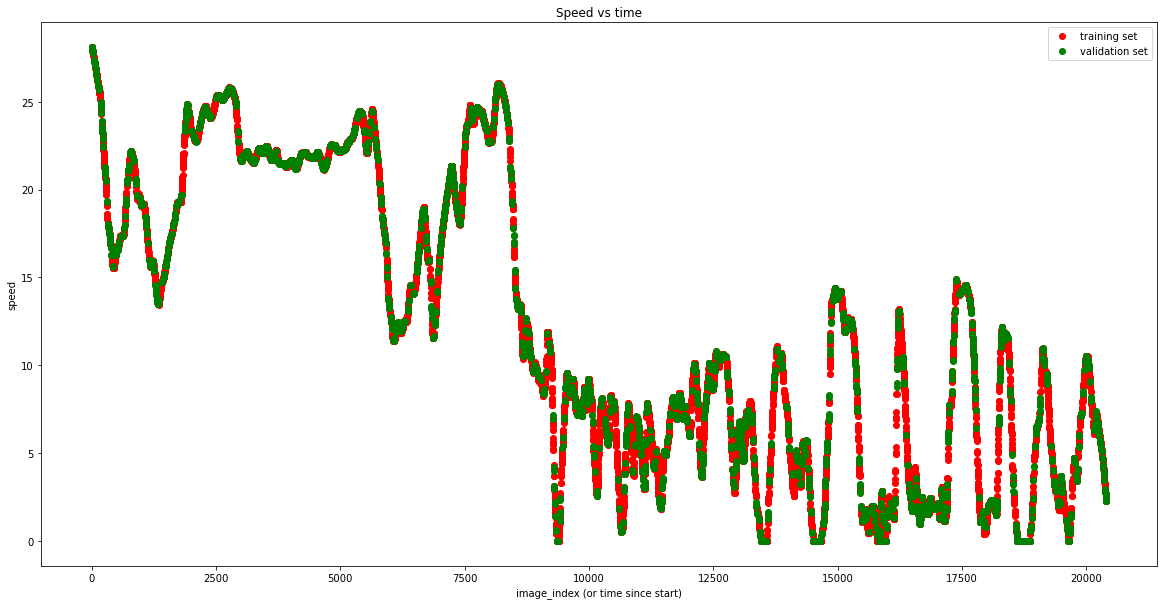

----
valid_data:        index                                         image_path  image_index  \
0       235  ../Mini Project/data/clean_data/train_imgs/235...          235   
1       236  ../Mini Project/data/clean_data/train_imgs/236...          236   
2      5192  ../Mini Project/data/clean_data/train_imgs/519...         5192   
3      5193  ../Mini Project/data/clean_data/train_imgs/519...         5193   
4     10955  ../Mini Project/data/clean_data/train_imgs/109...        10955   
...     ...                                                ...          ...   
3229   9793  ../Mini Project/data/clean_data/train_imgs/979...         9793   
3230    270  ../Mini Project/data/clean_data/train_imgs/270...          270   
3231    271  ../Mini Project/data/clean_data/train_imgs/271...          271   
3232   2620  ../Mini Project/data/clean_data/train_imgs/262...         2620   
3233   2621  ../Mini Project/data/clean_data/train_imgs/262...         2621   

          speed  
0     22.497131

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
#plt.plot(test_data.sort_values(['image_index'])[['image_index']], test_data.sort_values(['image_index'])[['speed']], 'bo')

plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set', 'testing set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data)
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data)
print('train_data: ', train_data.shape)
#print('test_data: ', test_data.shape)

In [11]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [12]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [13]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image



original image shape: (480, 640, 3)


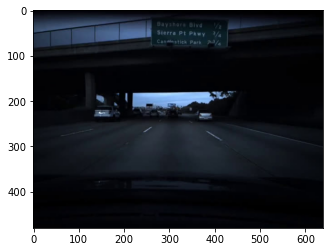

post prosessed image: (66, 220, 3)


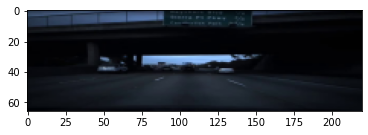

In [14]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [15]:
def preprocess_image_valid_from_path(image_path, speed, flipped):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    if flipped: 
        img = cv2.flip(img,1)
    else:
        pass
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor, flipped):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = change_brightness(img, bright_factor)    
        img = preprocess_image(img)
        if flipped: 
            img = cv2.flip(img,1)
        else: 
            pass
        return img, speed

In [16]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    num_samples = len(data)
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, num_samples - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor,
                                               flipped = False)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor,
                                               flipped = False)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield image_batch, label_batch

In [22]:
# def generate_training_data(data, batch_size = 32):
#     image_batch = np.zeros((2*batch_size, 66, 220, 3)) # nvidia input params
#     label_batch = np.zeros((2*batch_size))
#     while True:
#         for i in range(0,2*batch_size -1,2):
#             # generate a random index with a uniform random distribution from 1 to len - 1
#             idx = np.random.randint(1, len(data) - 1)
            
#             # Generate a random bright factor to apply to both images
#             bright_factor = 0.2 + np.random.uniform()
            
#             row_now = data.iloc[[idx]].reset_index()
#             row_prev = data.iloc[[idx - 1]].reset_index()
#             row_next = data.iloc[[idx + 1]].reset_index()
            
#             # Find the 3 respective times to determine frame order (current -> next)
            
#             time_now = row_now['image_index'].values[0]
#             time_prev = row_prev['image_index'].values[0]
#             time_next = row_next['image_index'].values[0]
            
#             if abs(time_now - time_prev) == 1 and time_now > time_prev:
#                 row1 = row_prev
#                 row2 = row_now
                
#             elif abs(time_next - time_now) == 1 and time_next > time_now:
#                 row1 = row_now
#                 row2 = row_next
#             else:
#                 print('Error generating row')            
            
#             x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
#                                                 row1['speed'].values[0],
#                                                bright_factor, 
#                                                flipped = False)
            
#             # preprocess another image
#             x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
#                                                 row2['speed'].values[0],
#                                                bright_factor, 
#                                                flipped = False)
           
#             # compute optical flow send in images as RGB
#             rgb_diff = opticalFlowDense(x1, x2)
                        
#             # calculate mean speed
#             y = np.mean([y1, y2])
            
#             image_batch[i] =rgb_diff
#             label_batch[i] = y
            
#             x1_flipped, y1_flipped = preprocess_image_from_path(row1['image_path'].values[0],
#                                                 row1['speed'].values[0],
#                                                bright_factor, 
#                                                flipped = True)
            
#             # preprocess another image
#             x2_flipped, y2_flipped = preprocess_image_from_path(row2['image_path'].values[0], 
#                                                 row2['speed'].values[0],
#                                                bright_factor, 
#                                                flipped = True)
           
#             # compute optical flow send in images as RGB
#             rgb_diff_flipped = opticalFlowDense(x1_flipped, x2_flipped)
                        
#             # calculate mean speed
#             y_flipped = np.mean([y1_flipped, y2_flipped])
            
#             image_batch[i + 1] = rgb_diff_flipped
#             label_batch[i + 1] = y_flipped

#         yield image_batch, label_batch

,index,image_path,image_index,speed
0,19279,../Mini Project/data/clean_data/train_imgs/192...,19279,5.463822
1,19280,../Mini Project/data/clean_data/train_imgs/192...,19280,5.465823
2,16332,../Mini Project/data/clean_data/train_imgs/163...,16332,9.099360
3,16333,../Mini Project/data/clean_data/train_imgs/163...,16333,9.123953
4,12645,../Mini Project/data/clean_data/train_imgs/126...,12645,10.504432


In [323]:
train_generator = generate_training_data(train_data)
next(train_generator)

(array([[[[-9.05059280e+01,  9.14201260e-01, -2.76617584e+01],
          [-1.20295685e+02,  1.21510792e+00, -4.84481773e+01],
          [-1.60827179e+02,  1.60827184e+00, -6.72444611e+01],
          ...,
          [-1.65764862e+02,  1.80591154e+00, -2.23933029e+02],
          [-1.31071198e+02,  1.42299342e+00, -1.72182205e+02],
          [-8.31959610e+01,  7.94229805e-01, -9.05421982e+01]],
 
         [[-1.40858368e+02,  1.39463735e+00, -3.09961700e+01],
          [-1.64393524e+02,  1.64393520e+00, -4.52586021e+01],
          [-1.84023499e+02,  1.80415189e+00, -6.45249557e+01],
          ...,
          [-2.32951492e+02,  1.95757556e+00, -8.69170837e+01],
          [-3.18006409e+02,  2.62815213e+00, -7.50019836e+01],
          [-4.33837799e+02,  3.49869204e+00, -6.66376343e+01]],
 
         [[-1.61820450e+02,  1.60218275e+00, -3.12082424e+01],
          [-2.03682938e+02,  1.99689150e+00, -4.54164238e+01],
          [-2.17003983e+02,  2.12749004e+00, -6.32428322e+01],
          ...,
    

In [809]:
# def generate_validation_data(data):
#     while True:
#         for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
#             row_now = data.iloc[[idx]].reset_index()
#             row_prev = data.iloc[[idx - 1]].reset_index()
#             row_next = data.iloc[[idx + 1]].reset_index()
            
#             # Find the 3 respective times to determine frame order (current -> next)
            
#             time_now = row_now['image_index'].values[0]
#             time_prev = row_prev['image_index'].values[0]
#             time_next = row_next['image_index'].values[0]
            
#             if abs(time_now - time_prev) == 1 and time_now > time_prev:
#                 row1 = row_prev
#                 row2 = row_now
                
#             elif abs(time_next - time_now) == 1 and time_next > time_now:
#                 row1 = row_now
#                 row2 = row_next
#             else:
#                 print('Error generating row')        
            
#             x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0],
#                                                flipped = False)
#             x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0],
#                                                flipped = False)
            
#             img_diff = opticalFlowDense(x1, x2)
#             img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
#             y = np.mean([y1, y2])
            
#             speed = np.array([[y]])
            
#             #print('img_diff', img_diff.shape, ' speed', speed)
#             yield img_diff, speed

In [61]:
def generate_validation_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               flipped = False)
            
            # preprocess another image
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               flipped = False)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] =rgb_diff
            label_batch[i] = y
            
        yield image_batch, label_batch

In [18]:
valid_generator = generate_validation_data(valid_data)
next(valid_generator)

(array([[[[ 2.17466021e+00, -2.30651550e+02, -2.34863297e+02],
          [ 2.91198516e+00, -3.05814972e+02, -3.11582397e+02],
          [ 3.67090535e+00, -3.85029083e+02, -3.92786865e+02],
          ...,
          [-1.38973343e+02,  2.71029139e+00, -2.98132050e+02],
          [-8.22281036e+01,  1.56232190e+00, -1.78104691e+02],
          [-4.25603828e+01,  8.31567764e-01, -9.47987213e+01]],
 
         [[ 2.60130739e+00, -2.73386810e+02, -2.78339905e+02],
          [ 3.47113776e+00, -3.57541779e+02, -3.64469452e+02],
          [ 4.34614515e+00, -4.47140717e+02, -4.56345245e+02],
          ...,
          [-1.59439224e+02,  3.09846902e+00, -3.43930054e+02],
          [-9.80829010e+01,  1.86873639e+00, -2.13035950e+02],
          [-5.38899536e+01,  1.00844431e+00, -1.20004875e+02]],
 
         [[ 2.56700945e+00, -2.61892242e+02, -2.66968994e+02],
          [ 3.42849874e+00, -3.45965454e+02, -3.53135376e+02],
          [ 4.31631708e+00, -4.39142120e+02, -4.48896973e+02],
          ...,
    

In [84]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    
    inputShape = (N_img_height, N_img_width, N_img_channels)
    
    model = tf.Sequential()
    
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Conv2D(24, 5, 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Conv2D(36, 5, 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Conv2D(48, 5, 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Conv2D(64, 3,
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Conv2D(64, 3,
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = adam, loss = 'mean_squared_error')

    
    return model

In [63]:
# hyperparameters
batch_size = 64
num_epochs = 25

valid_generator = generate_validation_data(valid_data, batch_size)
val_size = len(train_data)//(batch_size)

train_generator = generate_training_data(train_data, batch_size)
train_size = len(train_data)//(batch_size)

steps_per_epoch = train_size


# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model_{}_batch_size_{}_num_epoch_{}_steps_per_epoch_{}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH,"model_assets", run_name)
weights_loc = os.path.join(assets_filepath,"weights.h5")
history_loc =  os.path.join(assets_filepath,"history.p")


earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=3, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min')

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

#tensorboard = TensorBoard(log_dir=assets_filepath, histogram_freq=0, 
                         #write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping]

In [64]:
run_name

'model_nvidia_batch_size_64_num_epoch_25_steps_per_epoch_268'

In [85]:
model = nvidia_model()

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 220, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 108, 24)       1824      
_________________________________________________________________
elu (ELU)                    (None, 31, 108, 24)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 52, 36)        21636     
_________________________________________________________________
elu_1 (ELU)                  (None, 14, 52, 36)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 24, 48)         43248     
_________________________________________________________________
elu_2 (ELU)                  (None, 5, 24, 48)         0

In [88]:
history = model.fit(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

In [40]:
pickle.dump(history.history, open(history_loc, "wb"))

# Analysis

In [24]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0],
                                                  row1['speed'].values[0], 
                                                  flipped = False)
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0],
                                                  row2['speed'].values[0], 
                                                  flipped = False)
        
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
        data.loc[data['image_index']==time_now, 'error'] = error[0][0]

In [25]:
make_predictions(valid_data)

  0%|          | 0/3232 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████| 3232/3232 [02:56<00:00, 18.30it/s]


In [26]:
print(mean_squared_error(valid_data.iloc[1:-1, 3][~np.isnan(valid_data.iloc[1:-1, 3])], 
                         valid_data.iloc[1:-1, 4].fillna(0)))

3.459107303189646


dict_keys(['loss', 'val_loss'])


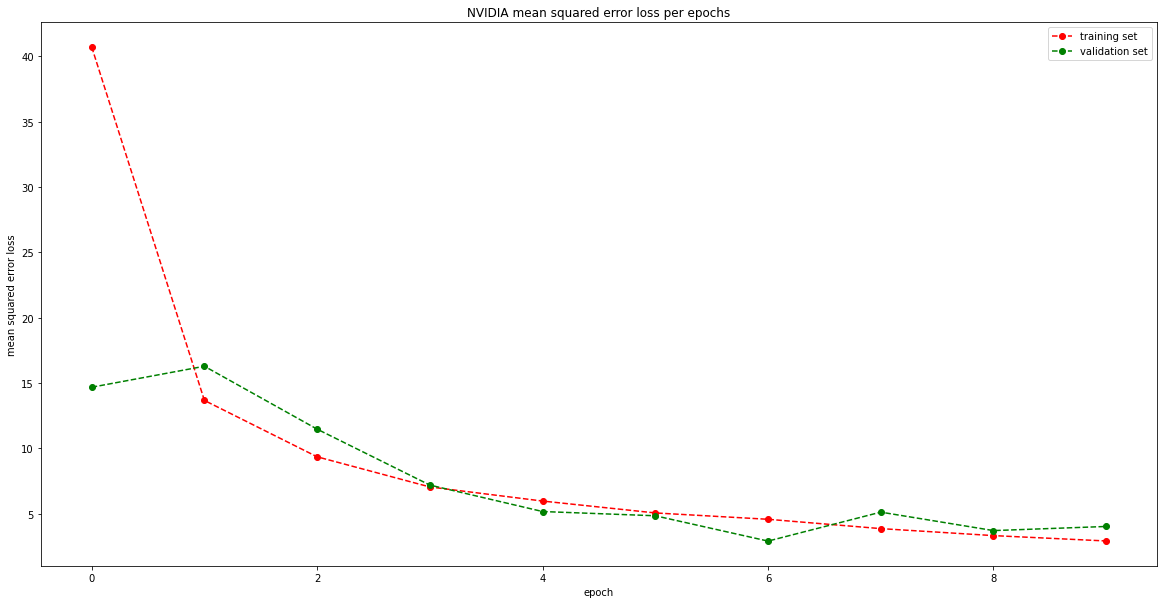

In [42]:
print(history.history.keys())

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('NVIDIA mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

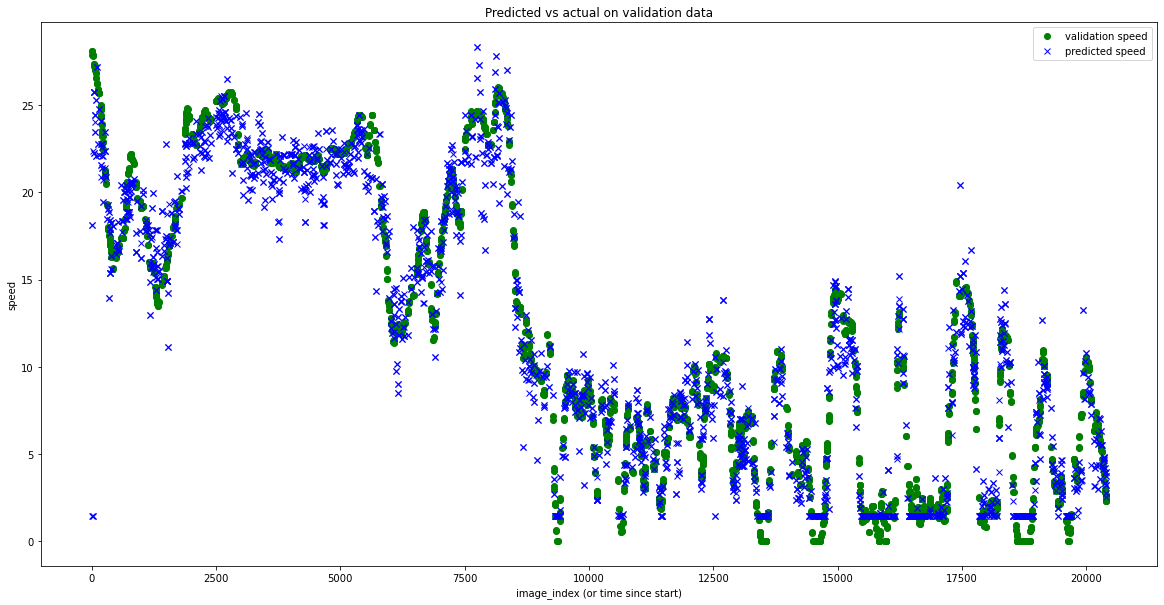

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [51]:
# fig, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
#          valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

# ax2 = ax1.twinx()
# ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
#          valid_data.sort_values(['image_index'])[['error']], 'co')

# ax1.set_xlabel('image_index (or time since start)')
# ax1.set_ylabel('speed')
# ax2.set_ylabel('prediction error')
# plt.title('Predicted vs actual on validation data')
# plt.legend(['prediction error'], loc='upper right')
# plt.show()
# plt.close()


<hr style="border:2px solid gray"> </hr>

# FlowNet S

In [39]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def flowNetS_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)
    model = tf.Sequential()
    
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Conv2D(64,(3,3),
                   padding='same',
                   kernel_initializer = 'he_normal',
                   name='conv0'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(64,(3,3),strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv1'))
    model.add(ELU())
    
    model.add(Conv2D(128,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv1_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(128,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv2'))
    model.add(ELU())
    
    model.add(Conv2D(128,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv2_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(256,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv3'))
    model.add(ELU())
    
    model.add(Conv2D(256,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv3_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(512,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv4'))
    model.add(ELU())
    
    model.add(Conv2D(512,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv4_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(512,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv5'))
    model.add(ELU())
    
    model.add(Conv2D(512,(3,3),
                     strides=(1,1),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv5_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(1024,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv6'))
    model.add(ELU())
    
    model.add(Conv2D(1024,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv6_1'))
    model.add(ELU())
    
    model.add(Conv2D(2,(3,3),padding='same',name='predict_flow'))
    model.add(ELU())
    model.add(Flatten(name = 'flatten'))
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = adam, loss = 'mean_squared_error')

    
    return model

In [35]:
# hyperparameters
batch_size = 64
num_epochs = 25

valid_generator = generate_validation_data(valid_data, batch_size)
val_size = len(train_data)//(batch_size)

train_generator = generate_training_data(train_data, batch_size)
train_size = len(train_data)//(batch_size)

steps_per_epoch = train_size


# run specific constants
model_name = 'flowNetS' #nvidia2
run_name = 'model_{}_batch_size_{}_num_epoch_{}_steps_per_epoch_{}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH,"model_assets", run_name)
weights_loc = os.path.join(assets_filepath,"weights.h5")
history_loc =  os.path.join(assets_filepath,"history.p")


earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=3, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min')

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

#tensorboard = TensorBoard(log_dir=assets_filepath, histogram_freq=0, 
                         #write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping]

In [33]:
run_name

'model_flowNetS_batch_size_64_num_epoch_25_steps_per_epoch_268'

In [36]:
model = flowNetS_model()
model.summary()

In [37]:
history = model.fit(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
268/268 [==============================] - ETA: 0s - loss: 25.6979WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C43B2C65E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

In [38]:
pickle.dump(history.history, open(history_loc, "wb"))

In [39]:
make_predictions(valid_data)

  0%|          | 0/3232 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████| 3232/3232 [03:28<00:00, 15.53it/s]


In [40]:
print(mean_squared_error(valid_data.iloc[1:-1, 3][~np.isnan(valid_data.iloc[1:-1, 3])], 
                         valid_data.iloc[1:-1, 4].fillna(0)))

1.2543809858378443


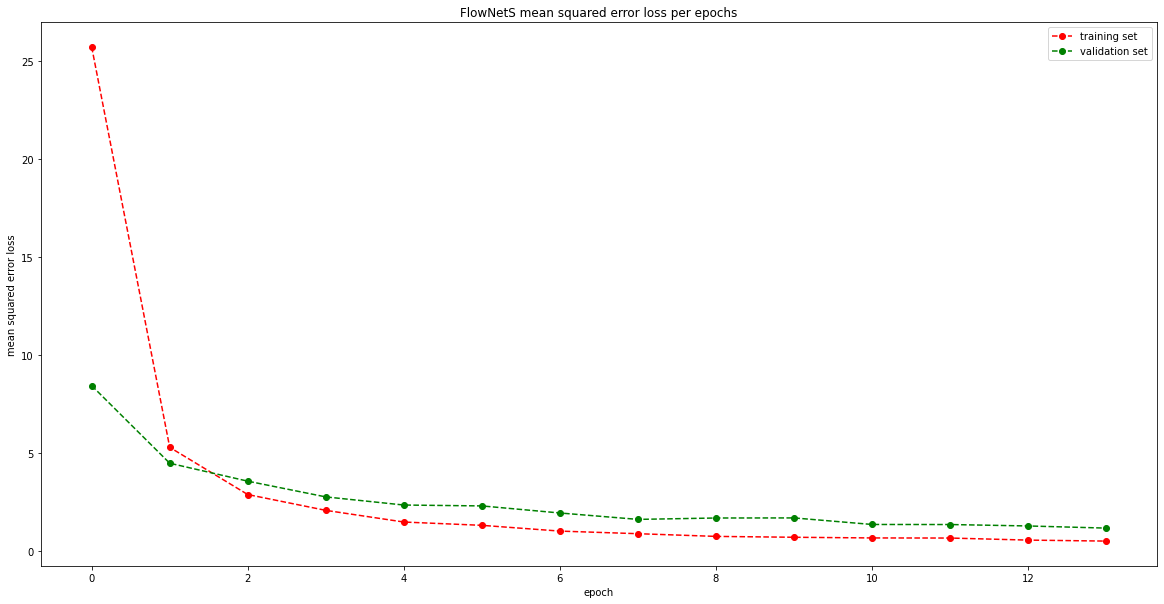

In [41]:
#print(history.history.keys())

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('FlowNetS mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

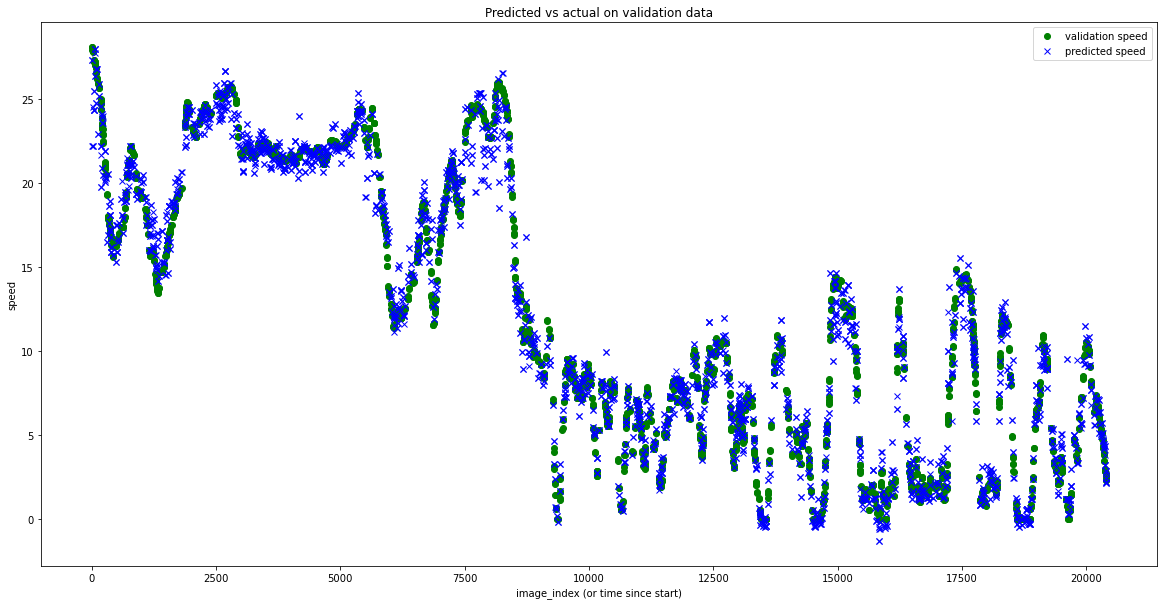

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

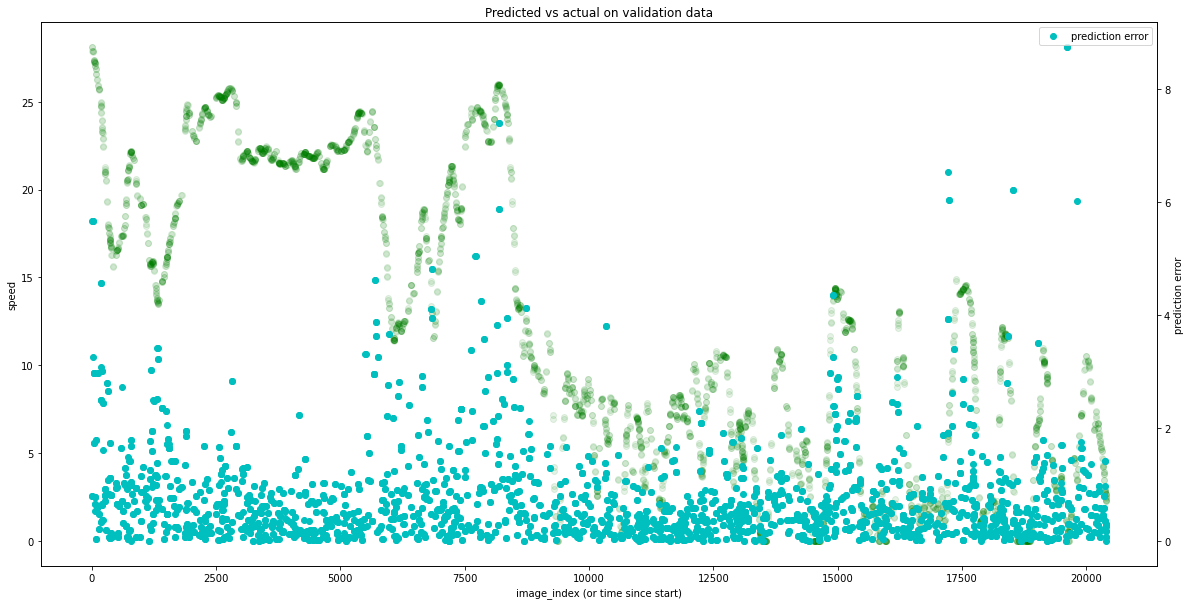

In [52]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')
ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

'float32'

<hr style="border:2px solid gray"> </hr>

## FlowNetCorr

In [17]:
def get_correlation_layer(input_l,input_r,max_displacement=5,stride2=2,height= 9,width=28):
    tf.backend.set_floatx('float64')
    conv_activation = lambda x: activations.relu(x,alpha=0.1) # Use the activation from the FlowNetC Caffe implementation
    conv1_l = Conv2D(64,(7,7), strides=(2,2), padding = 'same', name = 'conv1_l', activation=conv_activation)(input_l)
    conv2_l = Conv2D(128, (5, 5),  strides=(2,2),padding = 'same', name='conv2_l', activation=conv_activation)(conv1_l)
    conv3_l = Conv2D(256, (5, 5),  strides=(2,2),padding = 'same', name='conv3_l', activation=conv_activation)(conv2_l)
    conv1_r = Conv2D(64,(7,7), strides=(2,2), padding = 'same', name = 'conv1_r', activation=conv_activation)(input_r)
    conv2_r = Conv2D(128, (5, 5),  strides=(2,2),padding = 'same', name='conv2_r', activation=conv_activation)(conv1_r)
    conv3_r = Conv2D(256, (5, 5),  strides=(2,2),padding = 'same', name='conv3_r', activation=conv_activation)(conv2_r)
    
    output = []
    for i in range(-max_displacement + 1, max_displacement,stride2):
        for j in range(-max_displacement + 1, max_displacement,stride2):
            padded_a = pad(conv3_l, [[0,0], [0, abs(i)], [0, abs(j)], [0, 0]])
            padded_b = pad(conv3_r, [[0, 0], [abs(i), 0], [abs(j), 0], [0, 0]])
            m = padded_a * padded_b

            height_start_idx = 0 if i <= 0 else i
            height_end_idx = height_start_idx + 9
            width_start_idx = 0 if j <= 0 else j
            width_end_idx = width_start_idx + 28
            cut = m[:, height_start_idx:height_end_idx, width_start_idx:width_end_idx, :]

            final = reduce_sum(cut, axis=3)
            output.append(final)
    corr = stack(output, axis=3,name = 'corr_layer')
    
    conv3_l_redir = Conv2D(32,(3,3),padding = "same",name="conv_redir",activation=conv_activation)(conv3_l)
    concatenated_correlation = concatenate([conv3_l_redir,corr],axis = -1,name="concatenated_correlation")
    
    return concatenated_correlation

In [18]:
def generate_training_data_corr(data, batch_size = 32):
    image_batch_pre = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    image_batch_nxt = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    num_samples = len(data)
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, num_samples - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor,
                                               flipped = False)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor,
                                               flipped = False)
           
            # compute optical flow send in images as RGB
            rgb_diff_pre = opticalFlowDense(x1, x2)
            rgb_diff_nxt = opticalFlowDense(x2, x1)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch_pre[i] = rgb_diff_pre
            image_batch_nxt[i] = rgb_diff_nxt
            
            label_batch[i] = y
        corr_layer = get_correlation_layer(image_batch_pre, image_batch_nxt)
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield corr_layer.numpy(), label_batch

In [26]:
next(generate_training_data_corr(train_data, batch_size = 1))[0][0].shape

(9, 28, 57)

In [19]:
def generate_validation_data_corr(data, batch_size = 32):
    image_batch_pre = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    image_batch_nxt = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    num_samples = len(data)
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, num_samples - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               flipped = False)
            
            # preprocess another image
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               flipped = False)
           
            # compute optical flow send in images as RGB
            rgb_diff_pre = opticalFlowDense(x1, x2)
            rgb_diff_nxt = opticalFlowDense(x2, x1)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch_pre[i] = rgb_diff_pre
            image_batch_nxt[i] = rgb_diff_nxt
            
            label_batch[i] = y
        corr_layer = get_correlation_layer(image_batch_pre, image_batch_nxt)
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield corr_layer.numpy(), label_batch

In [48]:
next(generate_validation_data_corr(valid_data, batch_size = 1))

(array([[[[ 4.48719141e+01,  4.32731803e+01,  3.07151075e+01, ...,
            6.48435141e+05,  7.80294852e+05,  2.09774294e+05],
          [ 2.95312815e+01,  4.41147236e+01,  3.67341456e+01, ...,
            1.48811638e+06,  6.68026660e+05,  3.19502722e+05],
          [ 1.60560601e+01,  2.73622895e+01,  3.59421865e+01, ...,
            1.54733345e+06,  4.18946644e+05,  6.68177946e+05],
          ...,
          [-4.98966316e+00,  3.06906508e+01,  5.99675237e+01, ...,
            2.94645551e+05,  1.44873665e+05,  0.00000000e+00],
          [-1.49396089e+00,  2.47461464e+01,  8.10855881e+01, ...,
            1.95836724e+05,  0.00000000e+00,  0.00000000e+00],
          [ 2.07202928e+01, -1.03720666e+00,  9.00498341e+01, ...,
            1.01848610e+05,  0.00000000e+00,  0.00000000e+00]],
 
         [[ 1.48067517e+01,  1.59158844e+01,  1.22407594e+01, ...,
            4.20111334e+05,  4.22110393e+05,  1.92163752e+05],
          [ 1.05763357e+02, -1.35879181e+00,  4.22890290e+01, ...,
     

In [25]:
def flowNetCorr_model(N_img_height=9, N_img_width=28, N_img_channels=57):
    
    model = tf.Sequential()
    
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = (N_img_height,N_img_width,N_img_channels)))
    
    model.add(Conv2D(256,(3,3),
                   strides=(2,2),
                   padding='same',
                   kernel_initializer = 'he_normal',
                   name='conv3'))
    model.add(ELU())
    
    model.add(Conv2D(512,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv4'))
    model.add(ELU())
    
    model.add(Conv2D(512,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv4_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(512,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv5'))
    model.add(ELU())
    
    model.add(Conv2D(512,(3,3),
                     strides=(1,1),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv5_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(1024,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv6'))
    model.add(ELU())
    
    model.add(Conv2D(1024,(3,3),
                   padding='same',
                   kernel_initializer = 'he_normal',
                   name='conv6_1'))
    model.add(ELU())
    

    model.add(Conv2D(2,(3,3),padding='same',name='predict_flow'))
    model.add(ELU())
    model.add(Flatten(name = 'flatten'))
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = adam, loss = 'mean_squared_error')
    
    
    return model

In [29]:
# hyperparameters
batch_size = 64
num_epochs = 25

valid_generator = generate_validation_data_corr(valid_data, batch_size)
val_size = len(train_data)//(batch_size)

train_generator = generate_training_data_corr(train_data, batch_size)
train_size = len(train_data)//(batch_size)

steps_per_epoch = train_size


# run specific constants
model_name = 'flowNetCorr' #nvidia2
run_name = 'model_{}_batch_size_{}_num_epoch_{}_steps_per_epoch_{}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH,"model_assets", run_name)
weights_loc = os.path.join(assets_filepath,"weights.h5")
history_loc =  os.path.join(assets_filepath,"history.p")


earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=3, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min')

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

#tensorboard = TensorBoard(log_dir=assets_filepath, histogram_freq=0, 
                         #write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping]

In [34]:
run_name

In [35]:
model = flowNetCorr_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 9, 28, 57)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 14, 256)        131584    
_________________________________________________________________
elu (ELU)                    (None, 5, 14, 256)        0         
_________________________________________________________________
conv4 (Conv2D)               (None, 2, 6, 512)         1180160   
_________________________________________________________________
elu_1 (ELU)                  (None, 2, 6, 512)         0         
_________________________________________________________________
conv4_1 (Conv2D)             (None, 2, 6, 512)         2359808   
_________________________________________________________________
elu_2 (ELU)                  (None, 2, 6, 512)         0

In [37]:
history = model.fit(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

In [ ]:
pickle.dump(history.history, open(history_loc, "wb"))

In [ ]:
make_predictions(valid_data)

In [ ]:
print(mean_squared_error(valid_data.iloc[1:-1, 3][~np.isnan(valid_data.iloc[1:-1, 3])], 
                         valid_data.iloc[1:-1, 4].fillna(0)))

In [ ]:
print(history.history.keys())

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('FlowNetS mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')

ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

<hr style="border:2px solid gray"> </hr>

# Test Set Predictions

In [52]:
def make_test_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0],
                                                  row1['speed'].values[0], 
                                                  flipped = False)
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0],
                                                  row2['speed'].values[0], 
                                                  flipped = False)
        
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)        
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'speed'] = prediction[0][0]

In [21]:
assets_filepath = os.path.join(ASSETS_PATH,"model_assets")
os.listdir(assets_filepath)

['.ipynb_checkpoints',
 'flownets_weights.h5',
 'model_flowNetCorr_batch_size_64_num_epoch_25_steps_per_epoch_268',
 'model_flowNetS_batch_size_64_num_epoch_25_steps_per_epoch_268',
 'model_nvidia_batch_size_64_num_epoch_25_steps_per_epoch_268']

In [66]:
#load in testing meta data set
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test_meta.csv'))
assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
test_meta["speed"] = test_meta["speed"]
test_meta.head()

,image_path,image_index,speed
0,../Mini Project/data/clean_data/test_imgs/0.jpg,0,NaN
1,../Mini Project/data/clean_data/test_imgs/1.jpg,1,NaN
2,../Mini Project/data/clean_data/test_imgs/2.jpg,2,NaN
3,../Mini Project/data/clean_data/test_imgs/3.jpg,3,NaN
4,../Mini Project/data/clean_data/test_imgs/4.jpg,4,NaN


### Predict on test set using Nvidia model

'data\\clean_data\\assets\\model_assets\\model_nvidia_batch_size_64_num_epoch_25_steps_per_epoch_496'

In [22]:
# create model and load in best training weights
nvidia_model_path = os.path.join(ASSETS_PATH,"model_assets", 'model_nvidia_batch_size_64_num_epoch_25_steps_per_epoch_268')
nvidia_model_weights_path = os.path.join(nvidia_model_path, 'weights.h5')
model = nvidia_model()
model.load_weights(nvidia_model_weights_path)

In [34]:
make_test_predictions(test_meta)

  0%|          | 0/10796 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████| 10796/10796 [09:07<00:00, 19.70it/s]


In [ ]:
test_meta.loc[:,'speed']

In [44]:
# save prediction value as test_meta csv and text file with just speeds arranged in descending image order
prediction_path = os.path.join(nvidia_model_path, 'prediction')
test_meta.to_csv(os.path.join(prediction_path, 'test_meta_predicted.csv'), index=False)

In [61]:
prediction_path = os.path.join(nvidia_model_path, 'prediction')
test_meta = pd.read_csv(os.path.join(prediction_path, 'test_meta_predicted.csv'))

In [62]:
test_meta.head()

,image_path,image_index,speed
0,../Mini Project/data/clean_data/test_imgs/0.jpg,0,NaN
1,../Mini Project/data/clean_data/test_imgs/1.jpg,1,9.821154
2,../Mini Project/data/clean_data/test_imgs/2.jpg,2,12.643806
3,../Mini Project/data/clean_data/test_imgs/3.jpg,3,11.802845
4,../Mini Project/data/clean_data/test_imgs/4.jpg,4,7.773701


In [65]:
predicted_speed = np.array(test_meta.loc[:,'speed'])
predicted_speed[np.isnan(predicted_speed)] = 0
file = os.path.join(prediction_path, "nvidia_test.txt")
with open(file, 'w+') as datafile_id:
#here you open the ascii file

    np.savetxt(datafile_id, predicted_speed, fmt='%.6f')
    #here the ascii file is written. 

### Predict on test set using FlowNetS model

In [46]:
#load in testing meta data set
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test_meta.csv'))
assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
test_meta["speed"] = test_meta["speed"]
test_meta.head()

,image_path,image_index,speed
0,../Mini Project/data/clean_data/test_imgs/0.jpg,0,NaN
1,../Mini Project/data/clean_data/test_imgs/1.jpg,1,NaN
2,../Mini Project/data/clean_data/test_imgs/2.jpg,2,NaN
3,../Mini Project/data/clean_data/test_imgs/3.jpg,3,NaN
4,../Mini Project/data/clean_data/test_imgs/4.jpg,4,NaN


In [51]:
# create model and load in best training weights
flowNetS_model_path =  os.path.join(ASSETS_PATH,"model_assets", 'model_flowNetS_batch_size_64_num_epoch_25_steps_per_epoch_268')
flowNetS_model_weights_path = os.path.join(flowNetS_model_path, 'weights.h5')
#model = flowNetS_model()
#model.load_weights(flowNetS_model_weights_path)

In [53]:
make_test_predictions(test_meta)

100%|██████████| 10796/10796 [12:08<00:00, 14.82it/s]


In [54]:
# save prediction value as test_meta csv and text file with just speeds arranged in descending image order
prediction_path = os.path.join(flowNetS_model_path, 'prediction')
test_meta.to_csv(os.path.join(prediction_path, 'test_meta_predicted.csv'), index=False)

In [55]:
predicted_speed = np.array(test_meta.loc[:,'speed'])
predicted_speed[np.isnan(predicted_speed)] = 0
file = os.path.join(prediction_path, "flowNetS_test.txt")
with open(file, 'w+') as datafile_id:
#here you open the ascii file

    np.savetxt(datafile_id, predicted_speed, fmt='%.6f')
    #here the ascii file is written. 

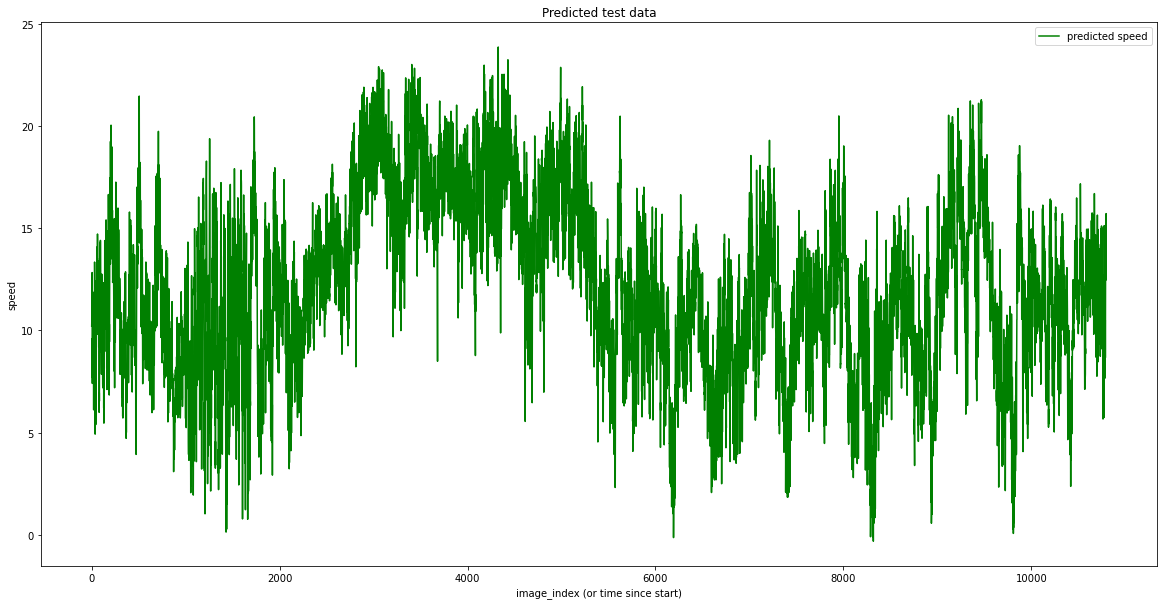

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['speed']], 'g-')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted test data')
plt.legend(['predicted speed'], loc='upper right')
plt.show()
plt.close()

### Predict on test set using FlowNetCorr model

In [ ]:
#load in testing meta data set
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test_meta.csv'))
assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
test_meta["speed"] = test_meta["speed"]
test_meta.head()

In [ ]:
# create model and load in best training weights
flowNetS_model_path =  os.path.join(ASSETS_PATH,"model_assets", 'model_flowNetS_batch_size_64_num_epoch_25_steps_per_epoch_496')
flowNetS_model_weights_path = os.path.join(flowNetS_model_path, 'weights.h5')
model = flowNetS_model()
model.load_weights(flowNetS_model_weights_path)

In [ ]:
make_test_predictions(test_meta)

In [ ]:
# save prediction value as test_meta csv and text file with just speeds arranged in descending image order
prediction_path = os.path.join(flowNetS_model_path, 'prediction')
test_meta.to_csv(os.path.join(prediction_path, 'test_meta_predicted.csv'), index=False)

In [ ]:
predicted_speed = np.array(test_meta.loc[:,'speed'])
predicted_speed[np.isnan(predicted_speed)] = 0
file = os.path.join(prediction_path, "flowNetS_test.txt")
with open(file, 'w+') as datafile_id:
#here you open the ascii file

    np.savetxt(datafile_id, predicted_speed, fmt='%.6f')
    #here the ascii file is written. 